In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats
# from sklearn.decomposition import PCA
import numpy as np
import math


In [2]:
df = pd.read_csv("data/train_cleaned.csv")


Splitting the features for categorical and numerical:

In [3]:
categorical_numeric_features = ["MSSubClass", "YrSold", "MoSold", "GarageCars"]
for category in categorical_numeric_features:
    df[category] = df[category].astype('category')

num_features = df.select_dtypes(include=['int64', 'float64']).columns
cat_features = df.select_dtypes(include=['object']).columns

print(f"Numerical Features: {len(num_features)}")
print(f"Categorical Features: {len(cat_features)}")

Numerical Features: 32
Categorical Features: 44


# Numerical features

In [4]:
for feature in num_features:
    n_unique = df[feature].nunique()
    print(f"{feature}: {n_unique} unique values")

LotFrontage: 306 unique values
LotArea: 1073 unique values
OverallQual: 10 unique values
OverallCond: 9 unique values
YearBuilt: 112 unique values
YearRemodAdd: 61 unique values
MasVnrArea: 327 unique values
BsmtFinSF1: 637 unique values
BsmtFinSF2: 144 unique values
BsmtUnfSF: 780 unique values
TotalBsmtSF: 721 unique values
1stFlrSF: 753 unique values
2ndFlrSF: 417 unique values
LowQualFinSF: 24 unique values
GrLivArea: 861 unique values
BsmtFullBath: 4 unique values
BsmtHalfBath: 3 unique values
FullBath: 4 unique values
HalfBath: 3 unique values
BedroomAbvGr: 8 unique values
KitchenAbvGr: 4 unique values
TotRmsAbvGrd: 12 unique values
Fireplaces: 4 unique values
GarageArea: 441 unique values
WoodDeckSF: 274 unique values
OpenPorchSF: 202 unique values
EnclosedPorch: 120 unique values
3SsnPorch: 20 unique values
ScreenPorch: 76 unique values
PoolArea: 8 unique values
MiscVal: 21 unique values
SalePrice: 663 unique values


Scatter plots?

For many of the numerical features, their numeric character is not real or needed, in such case we will change it to categorical binning them. In particular, if 95% of values for feature are 0, it should be just binary category instead.

In [5]:
def categorize_feature(df, feature, n_bins=5):
    """
    Categorizes a numerical feature into n bins.

    Parameters:
    - df (pd.DataFrame): The dataset containing the feature column.
    - feature (str): The name of the numerical feature to categorize.
    - n_bins (int): Number of categories to create.

    Returns:
    - pd.Series: A categorical feature representing the binned feature.
    """
    # Ensure the feature exists in the DataFrame
    if feature not in df.columns:
        raise ValueError(f"The dataframe must contain a '{feature}' column.")
    
    # If most values are zero, create a binary category
    if (df[feature] == 0).sum() / len(df) > 0.95:
        print(f'Feature {feature} changed into binary')
        return df[feature].apply(lambda x: "No Feature" if x == 0 else "Has Feature").astype('category')
    
    n_true_bins = min(df[feature].nunique(), n_bins)

    # Use quantile-based binning to split the values into n categories
    df[f'{feature}'] = pd.qcut(df[feature], q=n_true_bins, duplicates="drop")

    return df[f'{feature}']

In [6]:
df_categorized = df.copy()

categorized_features = []
for feature in num_features:
    if df_categorized[feature].nunique()<30:
        categorized_features.append(feature)
        df_categorized[feature] = categorize_feature(df_categorized,feature)
    n_unique = df_categorized[feature].nunique()
    # print(f"{feature}: {n_unique} unique values")
    
print(f'Features which are categorized:{categorized_features}')

Feature LowQualFinSF changed into binary
Feature 3SsnPorch changed into binary
Feature PoolArea changed into binary
Feature MiscVal changed into binary
Features which are categorized:['OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', '3SsnPorch', 'PoolArea', 'MiscVal']


After categorization, our features are:

In [7]:
num_features = df_categorized.select_dtypes(include=['int64', 'float64']).columns
cat_features = df_categorized.select_dtypes(include=['object', 'category']).columns

print(f"Numerical Features: {len(num_features)}")
print(f"Categorical Features: {len(cat_features)}")

Numerical Features: 18
Categorical Features: 62


# Visualization of numetrical features

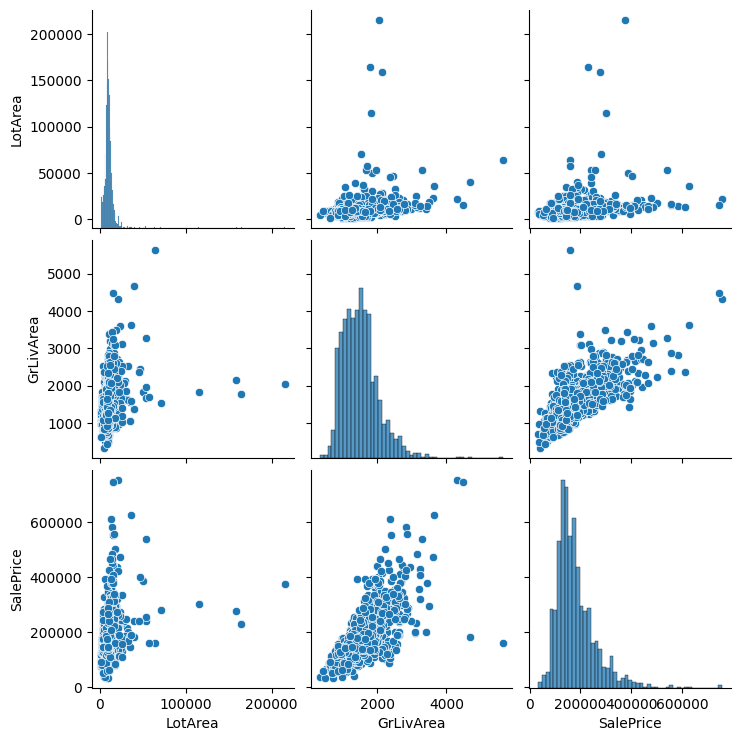

In [8]:
sns.pairplot(df_categorized.select_dtypes(include=['int64', 'float64']), vars=['LotArea', 'GrLivArea', 'SalePrice'])

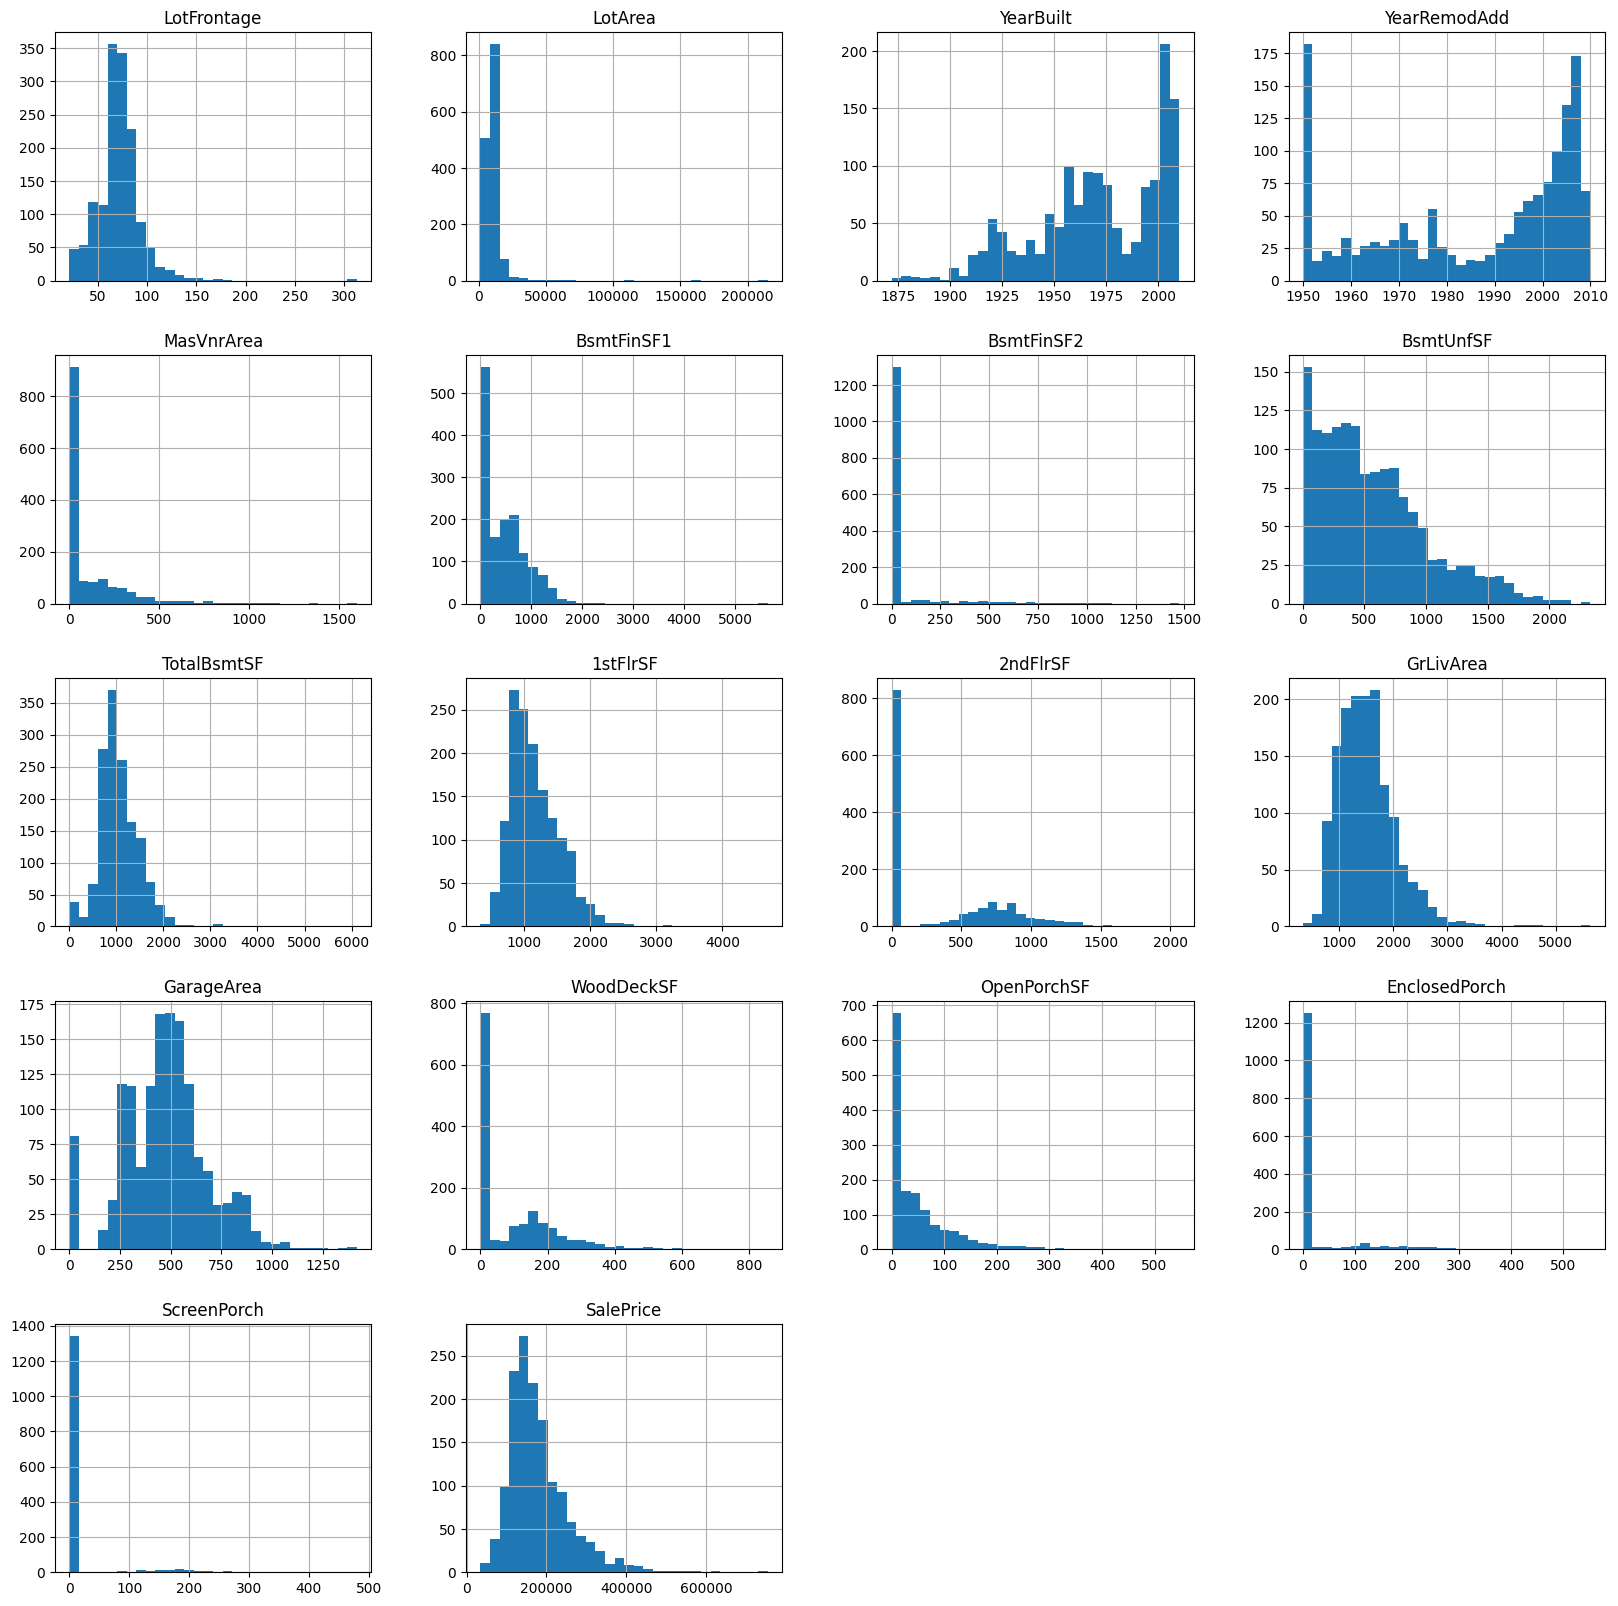

In [9]:
df_categorized[num_features].hist(figsize=(20, 20), bins=30)
plt.show()

Distribution of the Sale Price

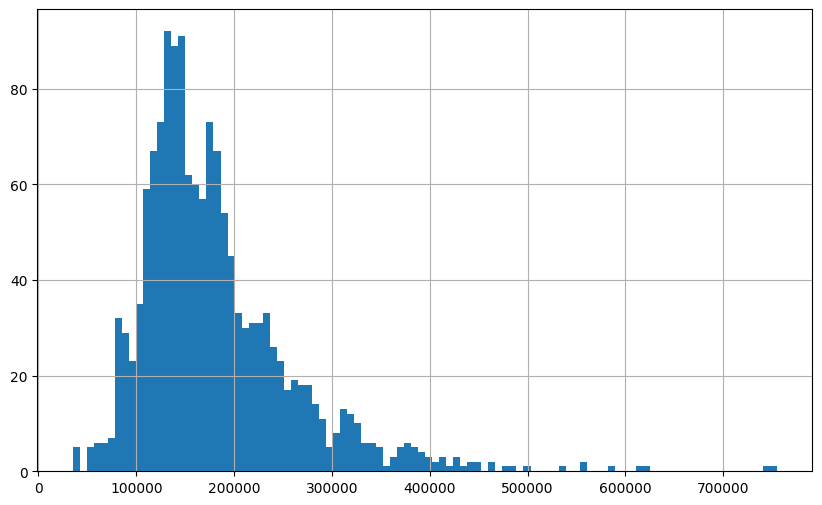

In [10]:
df["SalePrice"].hist(figsize=(10,6), bins=100)
plt.show()


From above we see that most of the numerical features are highly skewed + often span many orders of magnitude (as in SalePrice in (50 000, 750 000)). Examining in detail:

In [11]:
skewness = df_categorized[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skewness[abs(skewness) > 1]
print(f"There are {len(high_skew)} highly Skewed Features:\n", high_skew)

# Uncomment to display figure
# for feature in high_skew.index:
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     sns.histplot(df_categorized[feature].dropna(), kde=True)
#     plt.title(f'{feature} Distribution')
    
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=df_categorized[feature].dropna())
#     plt.title(f'{feature} Box Plot')
#     plt.tight_layout()
#     plt.show()

There are 13 highly Skewed Features:
 LotArea          12.195142
BsmtFinSF2        4.250888
ScreenPorch       4.117977
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
LotFrontage       2.118499
SalePrice         1.880941
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


We will reduce the skewness by applying log(1+x) to numercial features, examining what is the change in the skewness after the transformation

Transformation Summary:
               Original Skewness  Transformed Skewness
LotArea                12.195142             -0.137263
BsmtFinSF2              4.250888              2.521100
ScreenPorch             4.117977              3.147171
EnclosedPorch           3.086696              2.110104
MasVnrArea              2.674865              0.503014
OpenPorchSF             2.361912             -0.023373
LotFrontage             2.118499             -0.841879
SalePrice               1.880941              0.121222
BsmtFinSF1              1.683771             -0.617774
WoodDeckSF              1.539792              0.153379
1stFlrSF                1.375342              0.080032
GrLivArea               1.365156             -0.006134


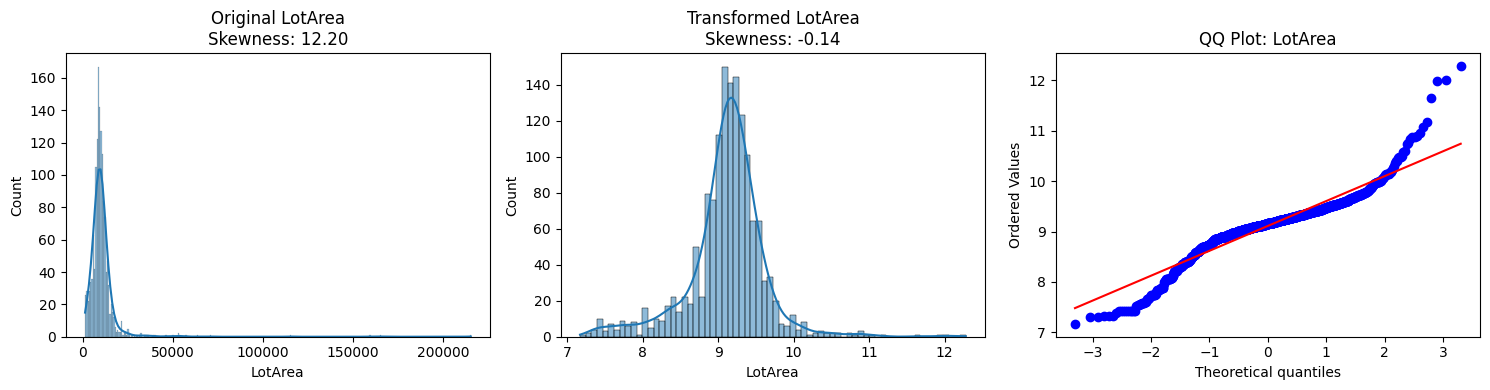

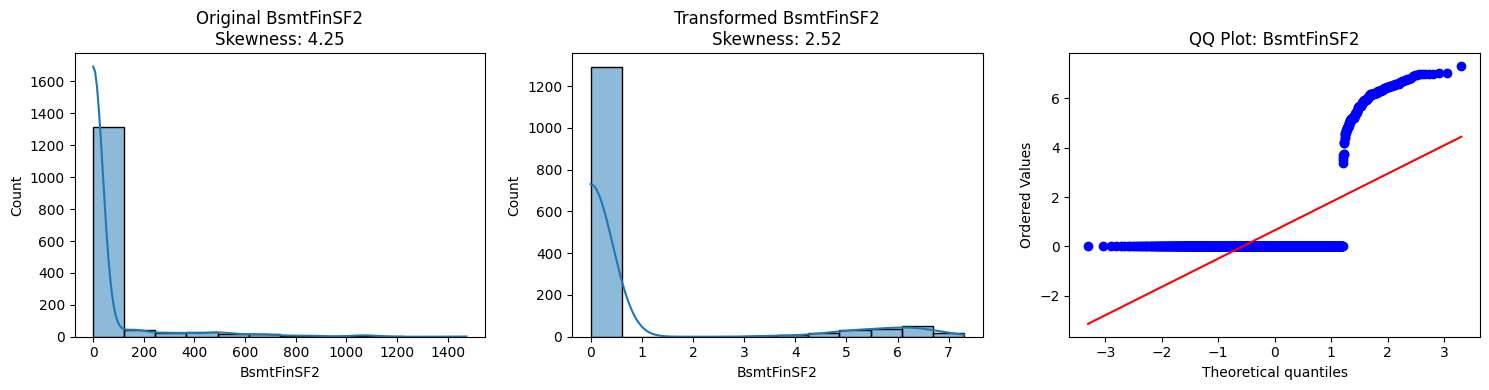

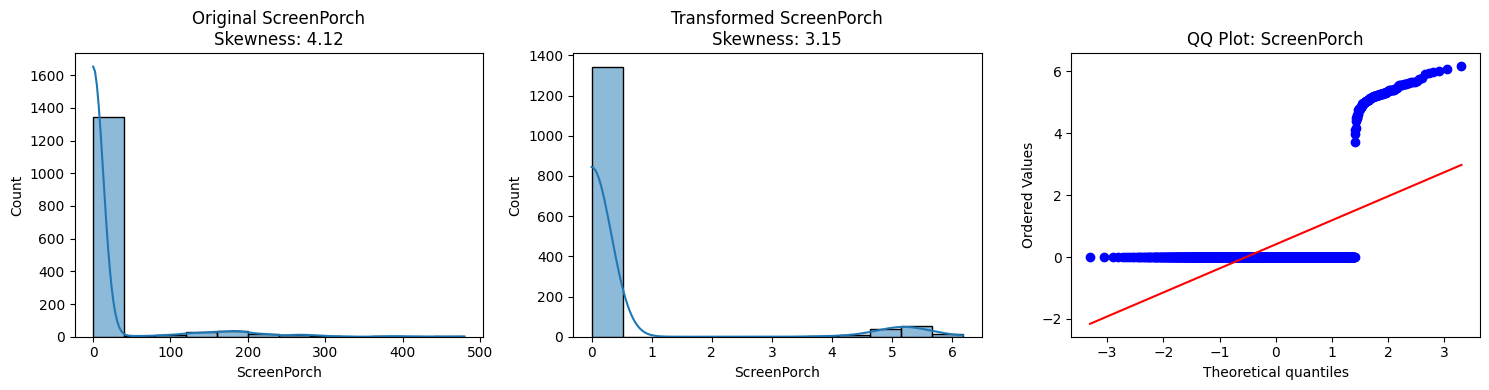

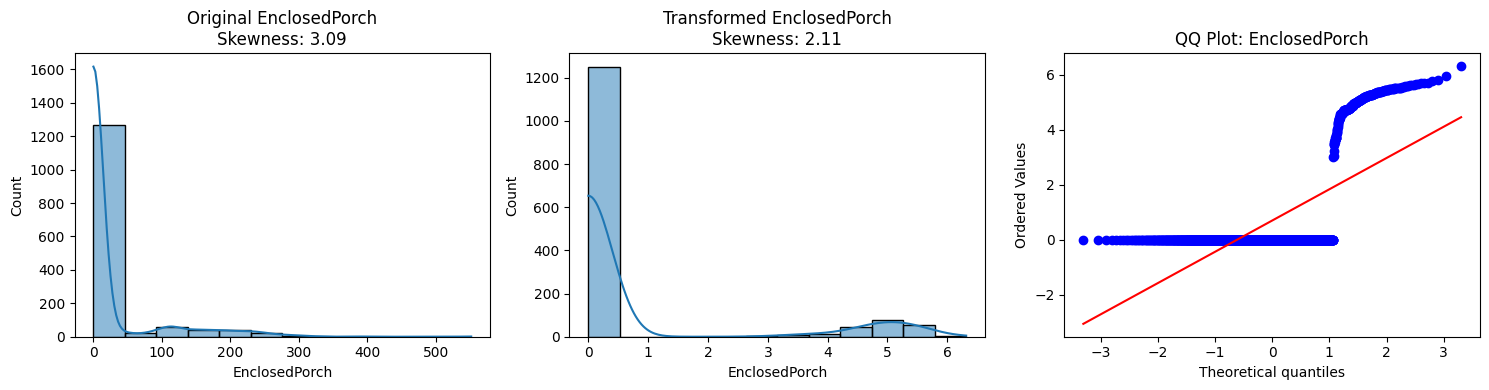

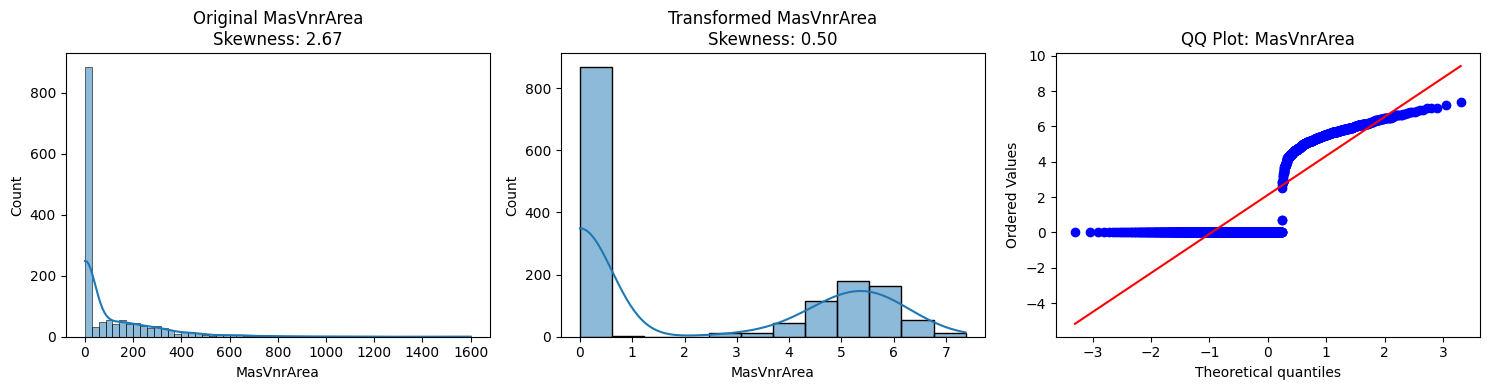

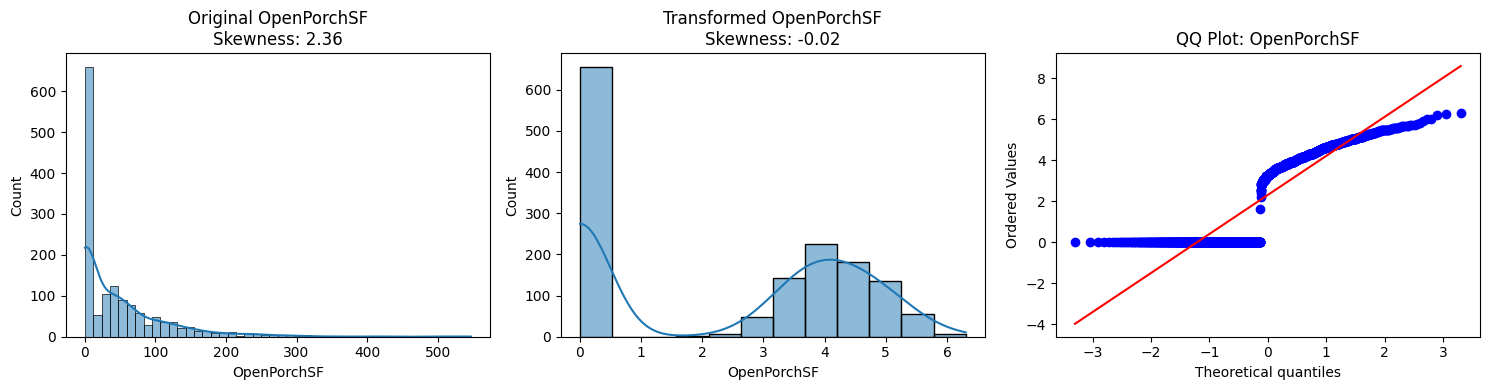

In [12]:


df_transformed = df_categorized.copy()

# checked that for TotalBsmtSF Log1 does not improve the skewness
features_to_transform = [feature for feature in high_skew.index if feature != 'TotalBsmtSF']

original_skewness = df[features_to_transform].apply(lambda x: stats.skew(x), axis=0)

transformed_data = pd.DataFrame(
    np.log1p(df[features_to_transform]), 
    columns=features_to_transform,
    index=df.index
)

# Replace original features with transformed values
for feature in features_to_transform:
    df_transformed[feature] = transformed_data[feature]

transformed_skewness = pd.Series({
    feature: stats.skew(df_transformed[feature]) 
    for feature in features_to_transform
})

# Create summary dataframe
transformation_summary = pd.DataFrame({
    'Original Skewness': original_skewness,
    'Transformed Skewness': [transformed_skewness[feature] for feature in features_to_transform]
})

transformation_summary = transformation_summary.sort_values('Original Skewness', ascending=False)

print("Transformation Summary:")
print(transformation_summary)

# Visualize before and after for the top most skewed features
top_features = transformation_summary.index[:6]  # Top 18 most skewed features

for feature in top_features:
    plt.figure(figsize=(15, 4))
    
    # Before transformation
    plt.subplot(1, 3, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Original {feature}\nSkewness: {original_skewness[feature]:.2f}')
    
    # After transformation
    plt.subplot(1, 3, 2)
    sns.histplot(df_transformed[feature], kde=True)
    plt.title(f'Transformed {feature}\nSkewness: {transformed_skewness[feature]:.2f}')
    
    # QQ plot to check normality
    plt.subplot(1, 3, 3)
    stats.probplot(df_transformed[feature], dist="norm", plot=plt)
    plt.title(f'QQ Plot: {feature}')
    
    plt.tight_layout()
    plt.show()

The remaining skewed features are:

In [13]:
skewness = df_transformed[num_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

high_skew = skewness[abs(skewness) >1]
print(f"There are {len(high_skew)} highly Skewed Features:\n", high_skew)

There are 4 highly Skewed Features:
 ScreenPorch      3.147171
BsmtFinSF2       2.521100
EnclosedPorch    2.110104
TotalBsmtSF      1.522688
dtype: float64


In [14]:
def detect_outliers(df, features, tolarated_outliers):
    outlier_dict = {}
    
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_dict[col] = len(outliers)
    
    return {k: v for k, v in sorted(outlier_dict.items(), key=lambda item: item[1], reverse=True) if v > tolarated_outliers}

outliers = detect_outliers(df, num_features, 50)
print("Features with Most (over 50) Outliers:", outliers, '\n')

Features with Most (over 50) Outliers: {'EnclosedPorch': 208, 'BsmtFinSF2': 167, 'ScreenPorch': 116, 'MasVnrArea': 98, 'LotFrontage': 94, 'OpenPorchSF': 77, 'LotArea': 69, 'TotalBsmtSF': 61, 'SalePrice': 61} 



Visualizing the outliers in the dataset to determine if they are error when collecting data

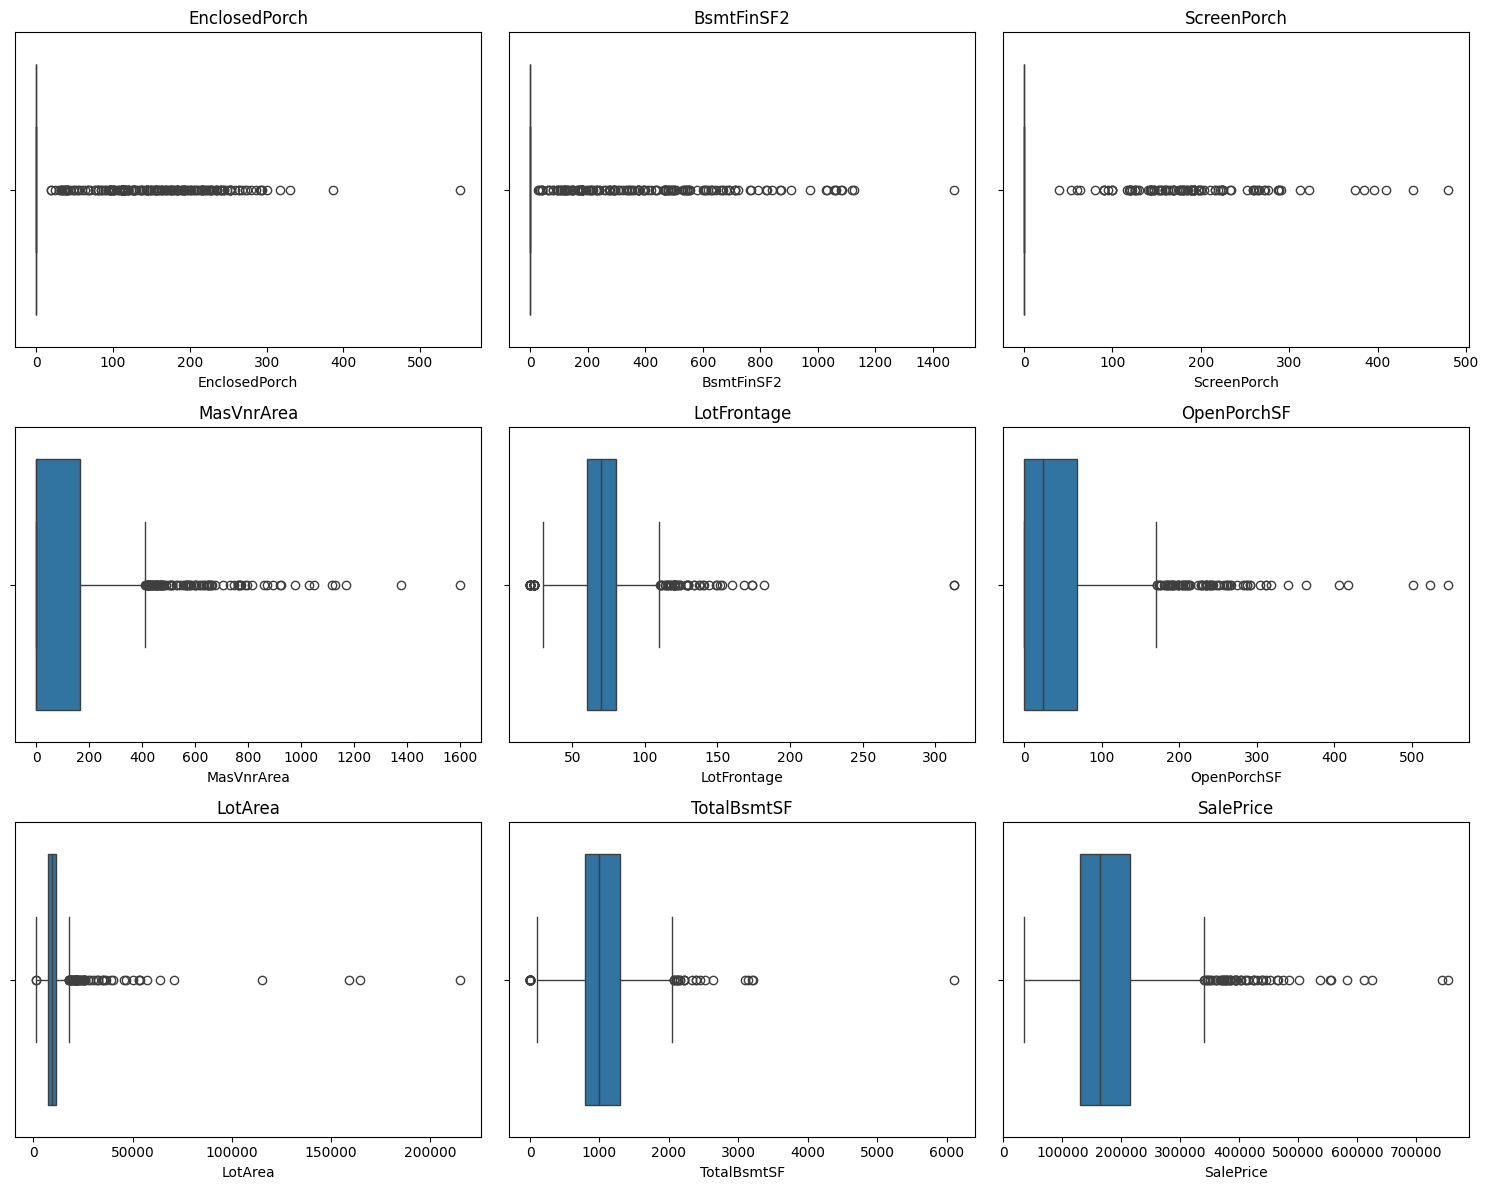

In [15]:
features = list(outliers.keys())
cols = 3  # you can adjust the number of columns
rows = math.ceil(len(features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(feature)
    
# Remove any empty subplots if the grid has extra cells
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

For those features it isn't surprising that some outlier are present. For top 3 we could categorize those features , but now we will let it be.

# Correlation analysis

In [16]:
# Correlation with target variable
corr_with_target = df_transformed[num_features].corrwith(df_transformed["SalePrice"]).sort_values(ascending=False)

# Show highly correlated features (above 0.5) and weakly correlated (below 0.1)
print("Highly Correlated Features with SalePrice:\n", corr_with_target[corr_with_target > 0.2])
print("\nWeakly Correlated Features:\n", corr_with_target[abs(corr_with_target) < 0.1])


Highly Correlated Features with SalePrice:
 SalePrice       1.000000
GrLivArea       0.730254
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.608955
YearBuilt       0.586570
YearRemodAdd    0.565608
OpenPorchSF     0.459948
MasVnrArea      0.413318
LotArea         0.399923
LotFrontage     0.375337
WoodDeckSF      0.343039
2ndFlrSF        0.319300
BsmtUnfSF       0.221985
BsmtFinSF1      0.208099
dtype: float64

Weakly Correlated Features:
 BsmtFinSF2   -0.030361
dtype: float64


In [17]:
# Compute correlation matrix
df_copy = df_transformed[num_features].copy()

#check if the last column is sale price.
if df_copy.columns[-1] == "SalePrice":
    df_copy = df_copy.drop(df_copy.columns[[-1]], axis=1)
else:
    print("SalePrice was not the last column, or was not present")
    print("The last column found was: ", df_copy.columns[-1])

corr_matrix = df_copy.corr()

# Find pairs with correlation > 0.5
high_corr = corr_matrix.abs().stack().reset_index()
high_corr = high_corr[high_corr[0] > 0.6]
high_corr = high_corr[high_corr["level_0"] != high_corr["level_1"]].drop_duplicates()

print("Highly Correlated Feature Pairs:\n", high_corr)

Highly Correlated Feature Pairs:
          level_0      level_1         0
1    LotFrontage      LotArea  0.733217
17       LotArea  LotFrontage  0.733217
145  TotalBsmtSF     1stFlrSF  0.779616
161     1stFlrSF  TotalBsmtSF  0.779616
181     2ndFlrSF    GrLivArea  0.662944
197    GrLivArea     2ndFlrSF  0.662944


Correlation heatmap for numerical features

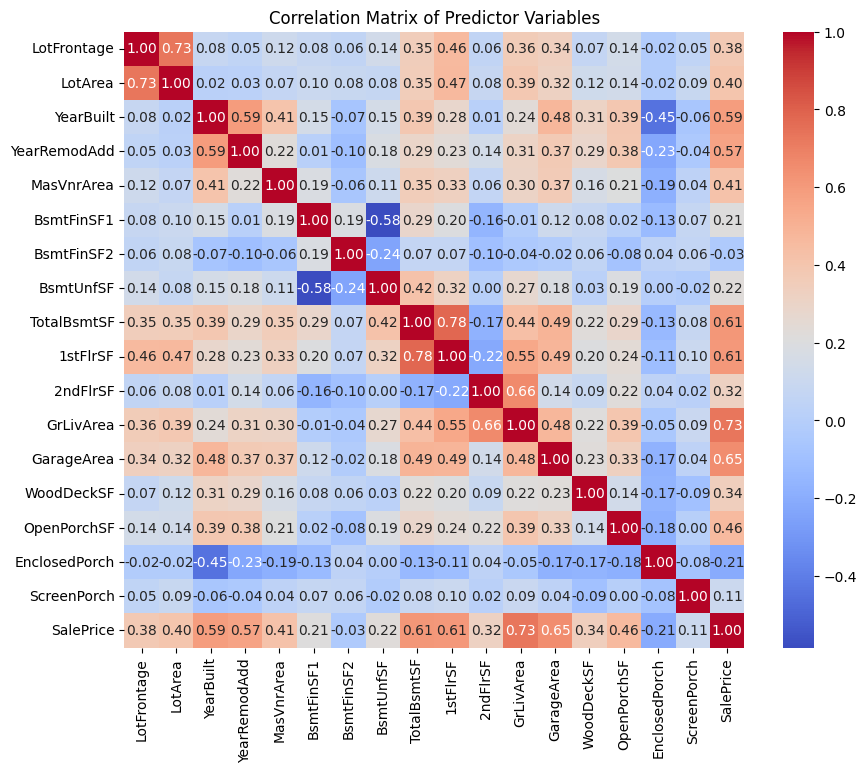

In [18]:

# Select only the predictor variables (exclude 'SalePrice')
predictors = df_transformed[num_features].drop('SalePrice', axis=1)

# Calculate the correlation matrix for the predictors
correlation_matrix = df_transformed[num_features].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Predictor Variables')
plt.show()

We will use pairwise PCA and take the 1st PC from each highly correlated pairs since they already explain most of the variance 

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Define your pairs of correlated features
pairs = [
    ['TotalBsmtSF', '1stFlrSF'],
    ['2ndFlrSF', 'GrLivArea'],
    ['LotArea', 'LotFrontage']
]

# Create a new dataframe for PCA components
pca_components = pd.DataFrame(index=df.index)

# Apply PCA to each pair separately
for i, pair in enumerate(pairs):
    # Skip pairs with missing values or handle them appropriately
    if df_copy[pair].isna().any().any():
        # Either impute missing values first or handle the pair differently
        df_pair = df_copy[pair].fillna(df_copy[pair].mean())
    else:
        df_pair = df_copy[pair]
    
    # Apply PCA to just this pair
    pca = PCA(n_components=1)
    pair_result = pca.fit_transform(df_pair)
    
    # Add the result to the components dataframe with a descriptive name
    pair_name = f"{pair[0]}_{pair[1]}_PC"
    pca_components[pair_name] = pair_result.flatten()
    
    # Optionally print explained variance for this pair
    print(f"Pair {pair[0]} & {pair[1]} - Variance explained: {pca.explained_variance_ratio_[0]:.2f}")

# Create final dataframe without the original correlated features
flat_pairs = [item for sublist in pairs for item in sublist]  # Flatten the list of pairs
df_new = df.drop(flat_pairs, axis=1)
df_PCA = pd.concat([df_new, pca_components], axis=1)

# Print shape to confirm
print(f"Original df shape: {df.shape}, New df shape: {df_PCA.shape}")


Pair TotalBsmtSF & 1stFlrSF - Variance explained: 1.00
Pair 2ndFlrSF & GrLivArea - Variance explained: 1.00
Pair LotArea & LotFrontage - Variance explained: 0.90
Original df shape: (1460, 80), New df shape: (1460, 77)


# Categorical features

For categorical features we will examine if between-group variation is substantially larger than the within-group variation using ANOVA

In [20]:


def analyze_categorical_features(df_input, cat_features, target='SalePrice', columns_to_drop=None, alpha = 0.05):
    """
    Main function to analyze categorical features with option to drop columns
    
    Parameters:
    -----------
    df_input : DataFrame
        The input dataframe to analyze
    cat_features : list
        List of categorical feature names
    target : str
        Target variable name
    columns_to_drop : list, optional
        List of column names to drop from the analysis
    """
    df = df_input.copy()
    
    if columns_to_drop is not None and len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop)
        print(f"Dropped columns: {columns_to_drop}")
        
        # Update cat_features to remove any dropped columns
        cat_features = [col for col in cat_features if col not in columns_to_drop]
        print(f"Remaining categorical features: {len(cat_features)}")
    
    #  reference line
    global_avg_price = df[target].mean()
    
    #  analyze a single categorical feature
    def analyze_categorical_feature(col):
        plt.figure(figsize=(14, 6))
        
        # Plot 1: Distribution of categories
        plt.subplot(1, 2, 1)
        counts = df[col].value_counts()
        sns.countplot(y=col, data=df, order=counts.index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        
        # Plot 2: Relationship with target
        plt.subplot(1, 2, 2)
        # Sort categories by their mean price
        cat_means = df.groupby(col)[target].mean().sort_values()
        cat_order = cat_means.index
        
        # Create box plot with sorted categories
        sns.boxplot(x=col, y=target, data=df, order=cat_order)
        plt.axhline(global_avg_price, color='r', linestyle='--', label=f'Avg {target}: ${global_avg_price:,.0f}')
        plt.legend()
        plt.title(f'{target} by {col}')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        stats_df = df.groupby(col)[target].agg(['count', 'mean', 'median', 'std']).sort_values('mean', ascending=False)
        
        # Add percent diff from global average
        stats_df['diff_from_avg'] = ((stats_df['mean'] - global_avg_price) / global_avg_price * 100).round(1)
        stats_df = stats_df.rename(columns={'diff_from_avg': '% diff from avg'})
        
        
        print(f"\nStatistics for {col}:")
        print(stats_df)
        
        # Calculate ANOVA 
        categories = df[col].unique()
        
        anova_groups = [df[df[col] == cat][target].values for cat in categories]
        anova_result = stats.f_oneway(*anova_groups)
        print(f"ANOVA p-value: {anova_result.pvalue:.6f} {'(Significant)' if anova_result.pvalue < alpha/len(cat_features) else '(Not significant)'}")
        
        
        return None
    
    
    
    # Function to prioritize categorical features
    def prioritize_categorical_features():
        feature_stats = []
        
        for col in cat_features:
            # Calculate ANOVA 
            categories = df[col].unique()
            if len(categories) > 1:
                anova_groups = [df[df[col] == cat][target].values for cat in categories]
                # Filter out empty groups
                anova_groups = [group for group in anova_groups if len(group) > 0]
                if len(anova_groups) > 1:
                    anova_result = stats.f_oneway(*anova_groups)
                    p_value = anova_result.pvalue
                else:
                    p_value = 1.0
            else:
                p_value = 1.0
            
            # Calculate max price difference between categories
            cat_means = df.groupby(col, observed=False)[target].mean()
            price_range = cat_means.max() - cat_means.min()
                
            feature_stats.append({
                'Feature': col,
                'ANOVA_p': p_value,
                'Bonferroni significance': p_value < alpha/len(cat_features),
                'Price_Range': price_range,
            })
        
        # Create DataFrame from statistics
        stats_df = pd.DataFrame(feature_stats)
        
        # Sort by statistical significance (ANOVA p-value)
        stats_df = stats_df.sort_values('ANOVA_p')
        
        return stats_df, stats_df[stats_df['Bonferroni significance'] == False]['Feature'].tolist()
    

    
    def compare_feature_significance(chosen_features=None):
        priority_df, _ = prioritize_categorical_features()

        plt.figure(figsize=(15, 10))
        plt.suptitle('Comparing Categorical Features', fontsize=16)

        for i, feature in enumerate(chosen_features):
            plt.subplot(2, len(chosen_features), i + 1)
            sns.violinplot(x=feature, y=target, data=df)
            plt.axhline(global_avg_price, color='r', linestyle='--')
            plt.title(f"Most Sig #{i + 1}: {feature}")
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

        
        print("\n Summary:")
        print(priority_df[priority_df['Feature'].isin(chosen_features)][['Feature', 'ANOVA_p', 'Bonferroni significance', 'Price_Range']])

        return None
    
    # Return functions for use
    return {
        'analyze_feature': analyze_categorical_feature,
        'prioritize_features': prioritize_categorical_features,
        'compare_significance': compare_feature_significance
    }


# First run with all columns and than repeat with only significant to make sure everything is significant than
# columns_to_drop = []
# Verified that those columns do not have large Bonferroni significance (alpha<0.05)
columns_to_drop = ['MiscFeature', 'Condition2', 'Street', 'LandSlope', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold', 'Utilities', 'YrSold', 'BsmtHalfBath']
# Initialize the analysis with a copy of the dataframe
analysis = analyze_categorical_features(df_PCA, cat_features, columns_to_drop=columns_to_drop)

# Get feature priorities 
priority_df, insignificant_features = analysis['prioritize_features']()
# print(priority_df)
print("Top significant features: \n", priority_df.head(5))
print("Least significant features: \n",priority_df.tail(5))

print("Insignificant features: \n",insignificant_features)





Dropped columns: ['MiscFeature', 'Condition2', 'Street', 'LandSlope', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold', 'Utilities', 'YrSold', 'BsmtHalfBath']
Remaining categorical features: 51
Top significant features: 
          Feature        ANOVA_p  Bonferroni significance    Price_Range
10   OverallQual   0.000000e+00                     True  388438.388889
6   Neighborhood  1.558600e-225                     True  236718.846485
42    GarageCars  1.121129e-211                     True  206318.837596
17     ExterQual  1.439551e-204                     True  279375.747253
20      BsmtQual  8.158548e-196                     True  221388.149430
Least significant features: 
          Feature       ANOVA_p  Bonferroni significance    Price_Range
47        PoolQC  7.700989e-07                     True  309595.336545
33  KitchenAbvGr  2.011735e-06                     True   73888.790230
5      LotConfig  3.163167e-06                     True   46916.569493
36    Functional  4.841697e-04  

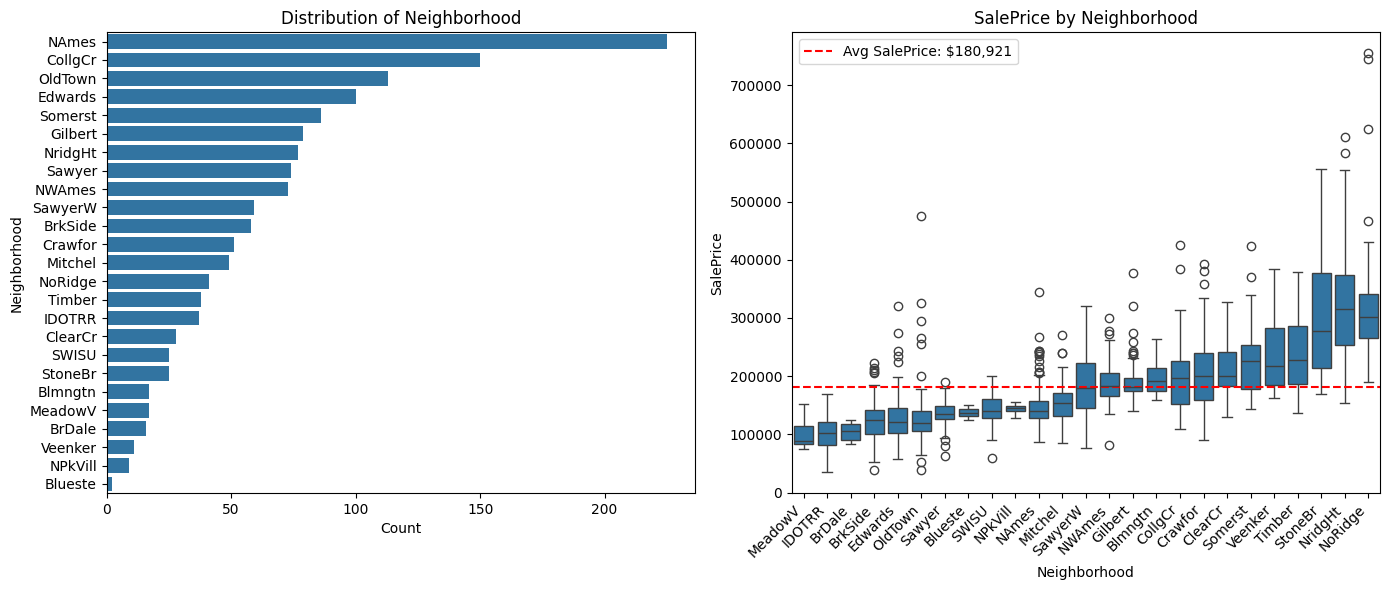


Statistics for Neighborhood:
              count           mean    median            std  % diff from avg
Neighborhood                                                                
NoRidge          41  335295.317073  301500.0  121412.658640             85.3
NridgHt          77  316270.623377  315000.0   96392.544954             74.8
StoneBr          25  310499.000000  278000.0  112969.676640             71.6
Timber           38  242247.447368  228475.0   64845.651549             33.9
Veenker          11  238772.727273  218000.0   72369.317959             32.0
Somerst          86  225379.837209  225500.0   56177.555888             24.6
ClearCr          28  212565.428571  200250.0   50231.538993             17.5
Crawfor          51  210624.725490  200624.0   68866.395472             16.4
CollgCr         150  197965.773333  197200.0   51403.666438              9.4
Blmngtn          17  194870.882353  191000.0   30393.229219              7.7
Gilbert          79  192854.506329  181000.0  

In [21]:
analysis['analyze_feature']('Neighborhood')

We can examine most and least significant categorcal features:

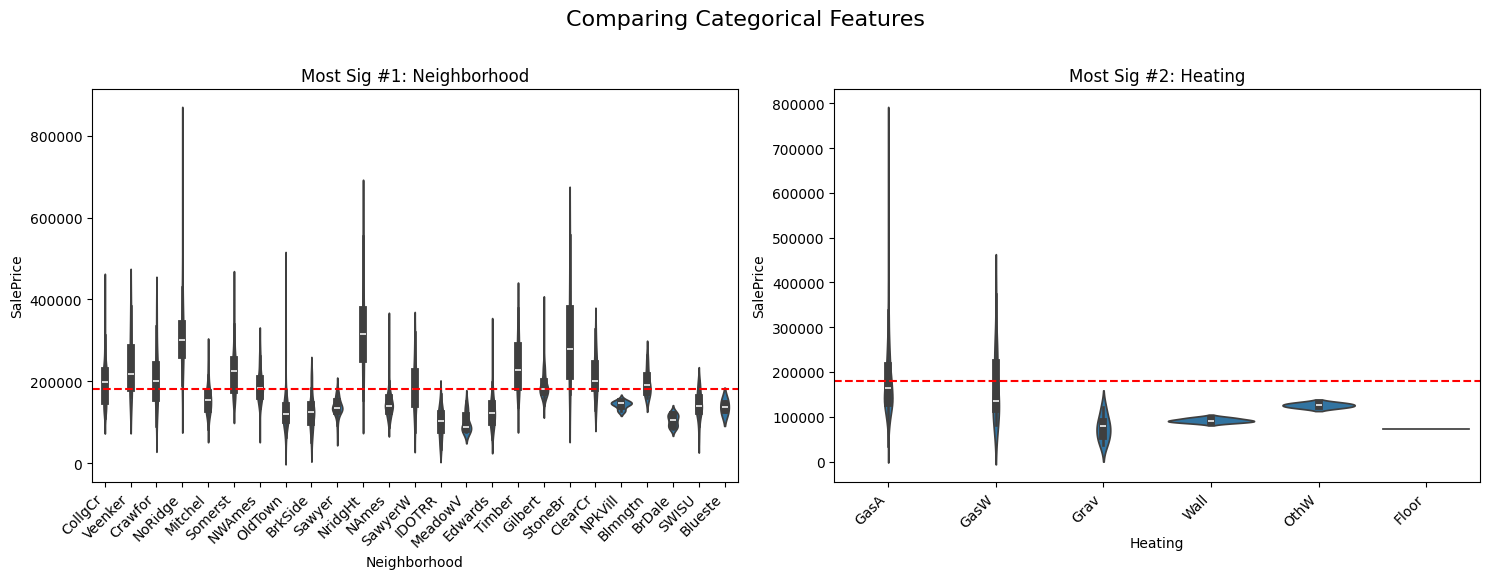


 Summary:
         Feature        ANOVA_p  Bonferroni significance    Price_Range
6   Neighborhood  1.558600e-225                     True  236718.846485
25       Heating   7.534721e-04                     True  109521.195378


In [22]:
analysis['compare_significance'](['Neighborhood', 'Heating'])

Dropping uncorrelated features which do not pass Bonferroni with 0.05/41

In [23]:
columns_to_drop = insignificant_features
df_dropped = df_PCA.drop(columns = columns_to_drop)
print(df_dropped.columns)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolAr

In [24]:
df_dropped.to_csv('data/train_transformed.csv', index=False)